## **Products categorization with Distilbert model**

The project concerns product categorization (multi-class text classification) based on their description by using pre-trained Distilbert model. Based on given text as an input, we have predicted what would be the category. In our analysis we have used a Huggingface (transformers) library as well.



In [1]:
#!pip install transformers

**Importing the required libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

C:\Users\rachel\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(tf.__version__)
print(keras.__version__)

2.6.0
2.6.0


We load previous cleaned up dataset.

In [4]:
df = pd.read_csv('labelled_data_objective_subjective_india.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,new_text,languages,translated,new_languages,pos_tagged_words,words_processed_all,words_processed_noun_adj_verb_adv,words_processed_noun,subjectivity,text_type
0,1,1,"#pickids : about 20,000 children perlis eligib...","#pickids : about 20,000 children perlis eligib...",ENGLISH,"#pickids : about 20,000 children perlis eligib...",ENGLISH,"[('pickins', 'NNS'), ('about', 'IN'), ('twenty...","['pickins', 'twenty', 'zero', 'child', 'peril'...","['child', 'peril', 'eligible', 'couid', 'vacci...","['child', 'peril', 'couid', 'vaccination']",0.000000,objective
1,2,2,previous covid-19 infection – but not vaccinat...,previous covid-19 infection – but not vaccinat...,ENGLISH,previous covid-19 infection – but not vaccinat...,ENGLISH,"[('previous', 'JJ'), ('couid', 'NN'), ('ninete...","['previous', 'couid', 'nineteen', 'infection',...","['previous', 'couid', 'infection', 'vaccinatio...","['couid', 'infection', 'vaccination', 'perform...",0.166667,objective
2,3,3,india’s covid-19 vaccination coverage crosses ...,india’s covid-19 vaccination coverage crosses ...,ENGLISH,india’s covid-19 vaccination coverage crosses ...,ENGLISH,"[('india', 'NN'), ('i', 'NN'), ('i', 'VBP'), (...","['india', 'couid', 'nineteen', 'vaccination', ...","['vaccination', 'mark']",['vaccination'],0.000000,objective
3,4,4,i got call office principal commissioner cgst ...,i got call office principal commissioner cgst ...,ENGLISH,i got call office principal commissioner cgst ...,ENGLISH,"[('i', 'NN'), ('got', 'VBD'), ('call', 'JJ'), ...","['got', 'call', 'office', 'principal', 'commis...","['get', 'call', 'office', 'ascertain', 'status...","['office', 'status', 'couid', 'vaccination', '...",0.000000,objective
4,5,5,"i have booked flight 13 feb, 2022 toronto new ...","i have booked flight 13 feb, 2022 toronto new ...",ENGLISH,"i have booked flight 13 feb, 2022 toronto new ...",ENGLISH,"[('i', 'NNS'), ('have', 'VBP'), ('booked', 'VB...","['booked', 'flight', 'thirteen', 'feb', 'toron...","['book', 'departure', 'time', 'let', 'know', '...","['departure', 'time', 'guideline', 'today', 'c...",0.727273,objective


In [5]:
df.shape

(1000, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0.1                       1000 non-null   int64  
 1   Unnamed: 0                         1000 non-null   int64  
 2   Text                               1000 non-null   object 
 3   new_text                           1000 non-null   object 
 4   languages                          1000 non-null   object 
 5   translated                         1000 non-null   object 
 6   new_languages                      1000 non-null   object 
 7   pos_tagged_words                   1000 non-null   object 
 8   words_processed_all                1000 non-null   object 
 9   words_processed_noun_adj_verb_adv  1000 non-null   object 
 10  words_processed_noun               1000 non-null   object 
 11  subjectivity                       1000 non-null   float6

In [7]:
#types of categories
df['text_type'].value_counts()

objective     669
subjective    331
Name: text_type, dtype: int64

### **Data preparation**

Spliting the data into train and test sets:

In [8]:
texts = df['words_processed_noun']
y = df['text_type']

In [9]:
texts

0             ['child', 'peril', 'couid', 'vaccination']
1      ['couid', 'infection', 'vaccination', 'perform...
2                                        ['vaccination']
3      ['office', 'status', 'couid', 'vaccination', '...
4      ['departure', 'time', 'guideline', 'today', 'c...
                             ...                        
995    ['business', 'capacity', 'couid', 'guideline',...
996                      ['schedule', 'patiala_politic']
997    ['team', 'couid', 'vaccination', 'certificate'...
998    ['vaccination', 'clinic', 'number', 'school', ...
999             ['precaution', 'vaccination', 'service']
Name: words_processed_noun, Length: 1000, dtype: object

In [10]:
new_text_noun = []

for row in texts:
    new_row = row.strip("][").replace("'","").split(", ")
    new_row = " ".join(new_row)
    new_text_noun.append(new_row)

In [11]:
new_text_noun

['child peril couid vaccination',
 'couid infection vaccination performance antibody',
 'vaccination',
 'office status couid vaccination thank commissioner cost',
 'departure time guideline today couid test vaccination certificate travel',
 'couid vaccination drive couid vaccine dose',
 'oscar attendee couid vaccination proof oscar ceremony',
 'couid vaccination school',
 'vaccination citizen',
 'number couid case second figure date',
 'couid vaccination number people atoll number people atoll number people atoll',
 'passenger vaccination couid order flight',
 'number couid case vaccination day pub',
 'vaccine dose today precaution category beneficiary vaccination',
 'couid vaccine dose',
 'necessity today scenario problem',
 'improve body resistance couid protection vaccine vaccination processbut side_effect',
 'population yrs offline class amp examination couid situation safety class amp examination couid vaccination',
 'educator risk health awareness home school community inch couid

In [12]:
df2 = pd.DataFrame(new_text_noun)

In [13]:
df2

,0
0,child peril couid vaccination
1,couid infection vaccination performance antibody
2,vaccination
3,office status couid vaccination thank commissi...
4,departure time guideline today couid test vacc...
...,...
995,business capacity couid guideline people yrs c...
996,schedule patiala_politic
997,team couid vaccination certificate daughter ph...
998,vaccination clinic number school college stude...


In [14]:
X = df2[0]

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [16]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### **DistilBERT model**

**DistilBERT**is a distilled version of BERT: smaller,faster, cheaper and lighter. It is a small, fast, cheap and light Transformer model trained by distilling BERT base. Because the BERT model has large size, it is difficult fot it to put it into production. Sometimes we want to use these model when we need a less weight yet efficient model. That's when we can use Distil-BERT model. It is  a smaller general-purpose language representation model, which can then be fine-tuned with good performances on a wide range of tasks like its larger counterparts. It has 40% less parameters than bert-base-uncased and runs 60% faster. It also has 97% of BERT’s performance while being trained on half of the parameters of BERT. 

In our task we have a small dataset and this model can be a good choice to try for us. 

In the first step we have to make tokenization on our dataset. Tokenization will allow us to feed batches of sequences into the model at the same time.

To do the tokenization of our datasets we have to choose a pre-trained model. We load the Distilbert model `(distilbert-base-uncased) `from the Huggingface Transformers library.

In [17]:
# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Now we have to load Distilbert model. In the Transformers library is avaliable Distilbert model and we use the `TFAutoModel` model (distilbert-base-uncased).

In [18]:
bert = TFAutoModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [19]:
for layer in bert.layers:
      layer.trainable = True

The function which allows to encode our dataset with tokenizer. We have decided on a maximum sentence length is 100 (maxlen).

In [20]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=280):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

Based on this encodings for our training and testing datasets are generated as follows:

In [21]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=280)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=280)

### **Build the model**

We create a Distilbert model with pretrained weights and then we add two Dense layers with Dropout layer.

In [77]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# model creation
def build_model(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(2,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
#    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
   model.compile(loss='binary_crossentropy', metrics=['acc',f1_m,precision_m,recall_m],optimizer='adam')

   return model

In [78]:
model = build_model(bert, maxlen=100)

We train the model for 10 epoch:

In [79]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=3
)

Epoch 1/3
25/25 [==============================] - 349s 13s/step - loss: 0.6592 - acc: 0.6550 - f1_m: 0.6550 - precision_m: 0.6550 - recall_m: 0.6550 - val_loss: 0.6580 - val_acc: 0.6400 - val_f1_m: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6250
Epoch 2/3
25/25 [==============================] - 318s 13s/step - loss: 0.6379 - acc: 0.6762 - f1_m: 0.6762 - precision_m: 0.6762 - recall_m: 0.6762 - val_loss: 0.6564 - val_acc: 0.6400 - val_f1_m: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6250
Epoch 3/3
25/25 [==============================] - 312s 13s/step - loss: 0.6410 - acc: 0.6762 - f1_m: 0.6762 - precision_m: 0.6762 - recall_m: 0.6762 - val_loss: 0.6602 - val_acc: 0.6400 - val_f1_m: 0.6250 - val_precision_m: 0.6250 - val_recall_m: 0.6250


Visualization of training:

In [80]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

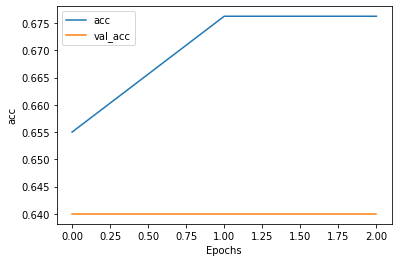

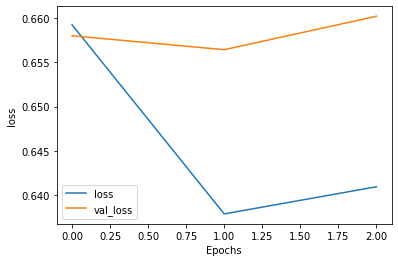

In [81]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

Predictions on a test set:

In [82]:
loss, accuracy, f1_score, precision, recall = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy)

7/7 [==============================] - 31s 4s/step - loss: 0.6602 - acc: 0.6400 - f1_m: 0.6250 - precision_m: 0.6250 - recall_m: 0.6250
Test accuracy : 0.6399999856948853


In [83]:
print('Test  f1_score :', f1_score)

Test  f1_score : 0.6249999403953552


In [67]:
len(y_test)

200

### **Summary**

For our analysis we have used a pretrained Distilbert model to resolve our  text classification problem. After trained model we achieved an accuracy on the test set equal to 93 % and it is a similar result in comparison to previous  models that we have used. We also tested a several models by adding layers and increase numbers of epochs but we do not achaived a better accuracy. 
